In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [85]:
import numpy as np 
import pandas as pd 

import re
import string
import nltk
from nltk.corpus import stopwords

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [86]:
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

In [87]:
print(os.listdir('../input/'))

['nlp-getting-started']


In [88]:
# Training Data
train = pd.read_csv("../input/nlp-getting-started/train.csv")
print("training data shape : ", train.shape)
train.head()

training data shape :  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [89]:
# Testing Data
# test data does not have a target column
test = pd.read_csv("../input/nlp-getting-started/test.csv")
print("testing data shape : ", test.shape)
test.head()

testing data shape :  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 3. Basic EDA
### Missing Values

In [90]:
# 결측치 확인하기
print(train.isnull().sum(), "\n")
print(test.isnull().sum())

# "text" of a tweet
# "keyword" from that tweet
# "location" the tweet was sent from

# 대부분 location에 결측치가 존재

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64 

id             0
keyword       26
location    1105
text           0
dtype: int64


### Exploring Target Column

In [91]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

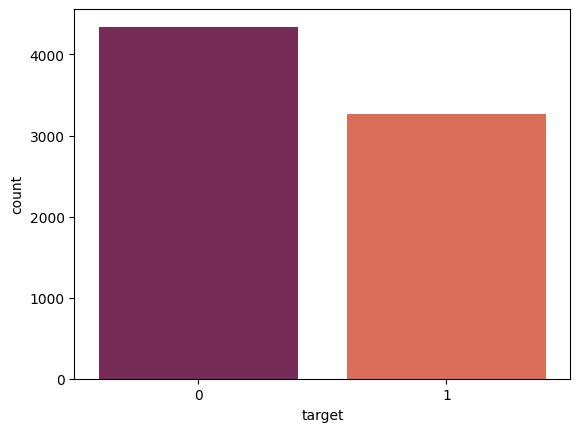

In [92]:
sns.barplot(x=train['target'].value_counts().index,y=train['target'].value_counts(),palette='rocket')

In [93]:
# disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [94]:
# non disaster tweets
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

### Exploring the 'keyword' column

<Axes: xlabel='count', ylabel='keyword'>

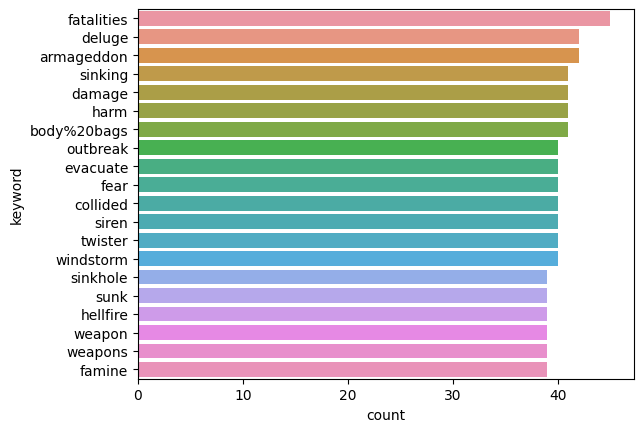

In [95]:
sns.barplot(y=train['keyword'].value_counts()[:20].index, 
            x=train['keyword'].value_counts()[:20], 
            orient='h')

In [96]:
# 1. How often the word 'disaster' come in the dataset
# 2. Whether this help us in determining whether a tweet belongs to a disaster category

train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

### Exploring 'location' column

In [97]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)


<Axes: xlabel='count', ylabel='location'>

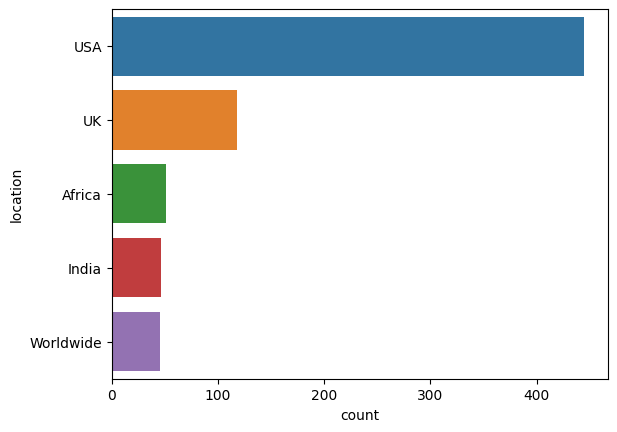

In [98]:
sns.barplot(y=train['location'].value_counts()[:5].index,
            x=train['location'].value_counts()[:5],
            orient='h')

# 4. Text Data Preprocessing
## 1. Data Cleaning
- case 통일하기
- 노이즈 제거
- 토큰화
    - 토큰화 이후 stemming 또는 lemmatization
- stopword 제거

In [99]:
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [100]:
def clean_text(text):
    # make text lowercase
    # remove square brakets
    # remove links
    # remove punctuation
    # remove numerical values
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [101]:
# 데이터에 적용
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [102]:
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

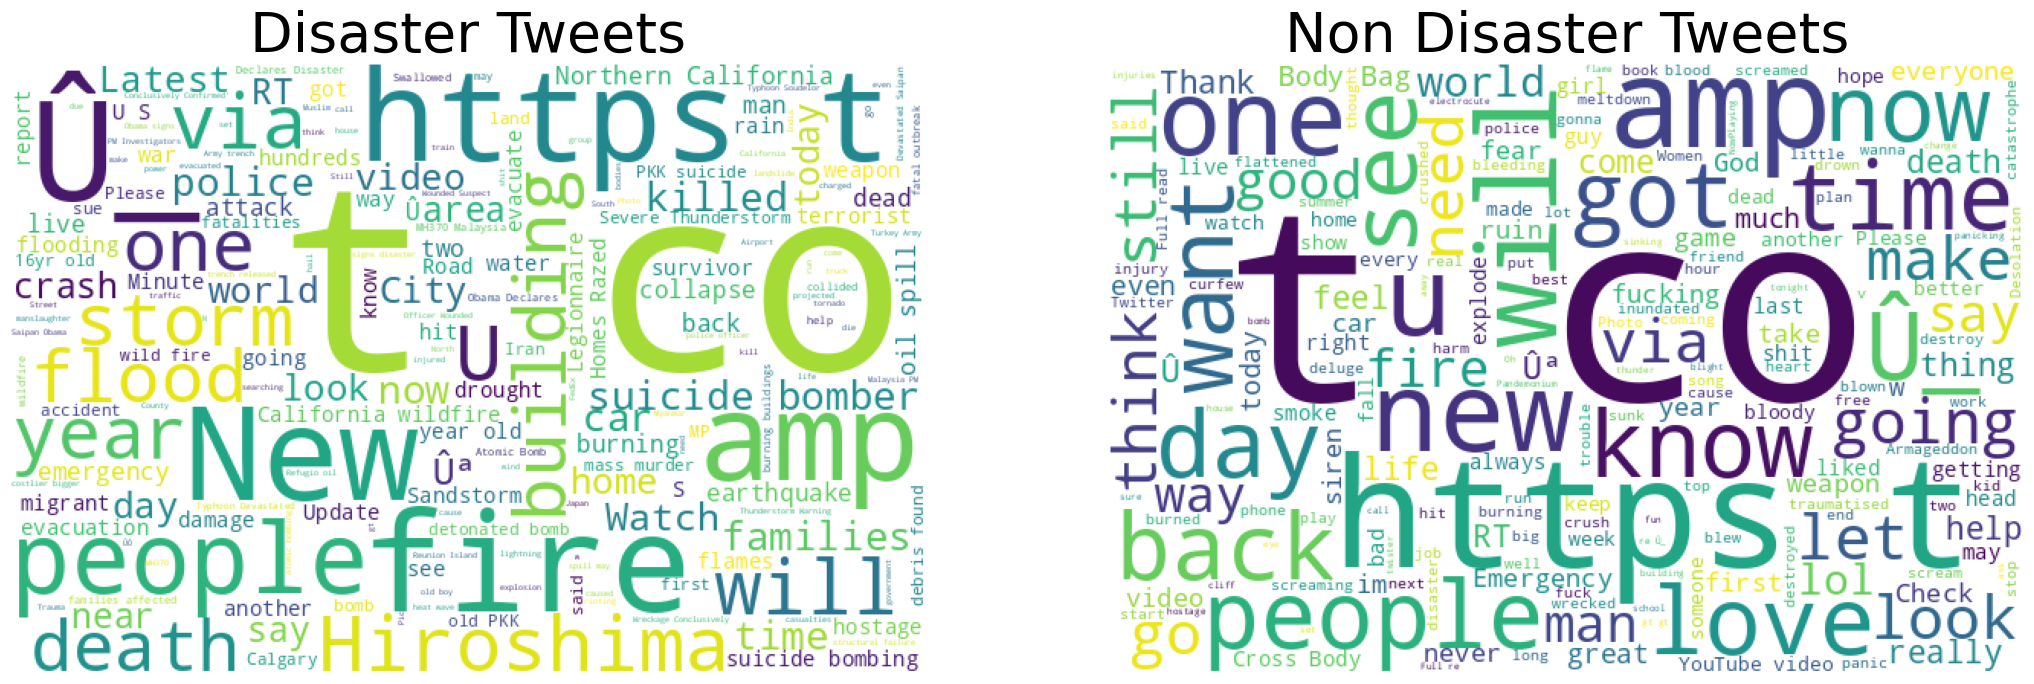

In [103]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud(background_color='white', width=600,
                       height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1) ; ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white', width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2) ; ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

## 2. Tokenization

In [104]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [105]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## 3. Stopwords Removal

In [106]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


## 4. Token Normalization

In [111]:
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
# print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk


In [112]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [113]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

## 5. Transforming tokens to a vector

In [114]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [115]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

# 6. Text Classification Model
## Logistic Regression Classifier

In [116]:
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [117]:
clf.fit(train_vectors, train["target"])

LogisticRegression()

In [118]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

## Naives Bayes Classifier

In [119]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [120]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB()

In [121]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [122]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB()

## XGBoost

In [123]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, 
                            n_estimators=200, 
                            colsample_bytree=0.8, 
                            subsample=0.8, 
                            nthread=10, 
                            learning_rate=0.1)

scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.49406688, 0.37087379, 0.43429637, 0.3780359 , 0.52307692])

In [124]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, 
                                  n_estimators=200, 
                                  colsample_bytree=0.8, 
                                  subsample=0.8, 
                                  nthread=10, 
                                  learning_rate=0.1)

scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.47191011, 0.36113837, 0.42638623, 0.38949672, 0.52812202])